In [56]:
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
import myconfig

## load data and drop columns

In [57]:
song_cluster = pd.read_csv('list_of_songs.csv')

In [58]:
song_cluster = pd.DataFrame(song_cluster)
song_cluster

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,duration_ms,time_signature,name_caller,id_other,name_other,id_caller.1,name_caller.1,id_other.1,name_other.1,id
0,0.747,0.716,11,-2.457,0,0.0750,0.135000,0.000000,0.2510,0.7510,...,210627,4,Starships,2EBCVPNAG46nbgs6jXPGvv,Starships,2EBCVPNAG46nbgs6jXPGvv,Starships,2EBCVPNAG46nbgs6jXPGvv,Starships,2EBCVPNAG46nbgs6jXPGvv
1,0.647,0.933,7,-4.056,1,0.1110,0.000351,0.002770,0.3340,0.3320,...,235107,4,Wild Strawberries,5b3Qc27BoDWebXdgtMO9hr,Wild Strawberries,5b3Qc27BoDWebXdgtMO9hr,Wild Strawberries,5b3Qc27BoDWebXdgtMO9hr,Wild Strawberries,5b3Qc27BoDWebXdgtMO9hr
2,0.734,0.809,10,-7.264,0,0.0839,0.026600,0.000000,0.0642,0.2540,...,232147,4,Papaoutai,34dx8DACTJsc3rsJdaEIQw,Papaoutai,34dx8DACTJsc3rsJdaEIQw,Papaoutai,34dx8DACTJsc3rsJdaEIQw,Papaoutai,34dx8DACTJsc3rsJdaEIQw
3,0.692,0.711,0,-7.498,0,0.0317,0.225000,0.000000,0.1200,0.8750,...,216933,4,Sweet Dreams (Are Made of This) - Remastered,1TfqLAPs4K3s2rJMoCokcS,Sweet Dreams (Are Made of This) - Remastered,1TfqLAPs4K3s2rJMoCokcS,Sweet Dreams (Are Made of This) - Remastered,1TfqLAPs4K3s2rJMoCokcS,Sweet Dreams (Are Made of This) - Remastered,1TfqLAPs4K3s2rJMoCokcS
4,0.317,0.887,9,-7.292,1,0.0375,0.000582,0.002580,0.0891,0.8710,...,220561,4,Rock and Roll - Remaster,4PRGxHpCpF2yoOHYKQIEwD,Rock and Roll - Remaster,4PRGxHpCpF2yoOHYKQIEwD,Rock and Roll - Remaster,4PRGxHpCpF2yoOHYKQIEwD,Rock and Roll - Remaster,4PRGxHpCpF2yoOHYKQIEwD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.545,0.953,7,-5.172,1,0.0441,0.000941,0.117000,0.2810,0.5580,...,216027,4,Cornfield Chase,6pWgRkpqVfxnj3WuIcJ7WP,Cornfield Chase,6pWgRkpqVfxnj3WuIcJ7WP,Cornfield Chase,6pWgRkpqVfxnj3WuIcJ7WP,Cornfield Chase,6pWgRkpqVfxnj3WuIcJ7WP
9995,0.337,0.977,9,-1.995,1,0.0976,0.004920,0.872000,0.2600,0.0582,...,345706,4,Omen,144adL7pGHEWRwute2wxzZ,Omen,144adL7pGHEWRwute2wxzZ,Omen,144adL7pGHEWRwute2wxzZ,Omen,144adL7pGHEWRwute2wxzZ
9996,0.726,0.903,7,-2.277,0,0.0357,0.055000,0.000225,0.1580,0.9580,...,211244,4,Dark Star - Homemade Weapons Remix,28d1X9lfagOD4iFULH4qEK,Dark Star - Homemade Weapons Remix,28d1X9lfagOD4iFULH4qEK,Dark Star - Homemade Weapons Remix,28d1X9lfagOD4iFULH4qEK,Dark Star - Homemade Weapons Remix,28d1X9lfagOD4iFULH4qEK
9997,0.645,0.891,6,-2.505,0,0.0387,0.093200,0.000004,0.3790,0.5680,...,203520,4,러시안 룰렛 Russian Roulette,5HiSc2ZCGn8L3cH3qSwzBT,러시안 룰렛 Russian Roulette,5HiSc2ZCGn8L3cH3qSwzBT,러시안 룰렛 Russian Roulette,5HiSc2ZCGn8L3cH3qSwzBT,러시안 룰렛 Russian Roulette,5HiSc2ZCGn8L3cH3qSwzBT


In [59]:
#create separate dataframe for song name and id
data = [song_cluster["name_caller"], song_cluster["id_caller.1"]]
headers = ["name", "id"]

song_df = pd.concat(data, axis=1, keys=headers)
song_df

,name,id
0,Starships,2EBCVPNAG46nbgs6jXPGvv
1,Wild Strawberries,5b3Qc27BoDWebXdgtMO9hr
2,Papaoutai,34dx8DACTJsc3rsJdaEIQw
3,Sweet Dreams (Are Made of This) - Remastered,1TfqLAPs4K3s2rJMoCokcS
4,Rock and Roll - Remaster,4PRGxHpCpF2yoOHYKQIEwD
...,...,...
9994,Cornfield Chase,6pWgRkpqVfxnj3WuIcJ7WP
9995,Omen,144adL7pGHEWRwute2wxzZ
9996,Dark Star - Homemade Weapons Remix,28d1X9lfagOD4iFULH4qEK
9997,러시안 룰렛 Russian Roulette,5HiSc2ZCGn8L3cH3qSwzBT


In [60]:
#drop unneccessary columns
song_cluster.drop(["time_signature"],axis=1, inplace=True)
song_cluster.drop(["name_other"],axis=1, inplace=True)
song_cluster.drop(["id_caller.1"],axis=1, inplace=True)
song_cluster.drop(["name_caller.1"],axis=1, inplace=True)
song_cluster.drop(["id_other.1"],axis=1, inplace=True)
song_cluster.drop(["name_other.1"],axis=1, inplace=True)
song_cluster.drop(["id"],axis=1, inplace=True)
song_cluster.drop(["type"],axis=1, inplace=True)
song_cluster.drop(["id_caller"],axis=1, inplace=True)
song_cluster.drop(["uri"],axis=1, inplace=True)
song_cluster.drop(["track_href"],axis=1, inplace=True)
song_cluster.drop(["analysis_url"],axis=1, inplace=True)
song_cluster.drop(["duration_ms"],axis=1, inplace=True)
song_cluster.drop(["name_caller"],axis=1, inplace=True)
song_cluster.drop(["id_other"],axis=1, inplace=True)

In [61]:
X = song_cluster
X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.747,0.716,11,-2.457,0,0.0750,0.135000,0.000000,0.2510,0.7510,125.008
1,0.647,0.933,7,-4.056,1,0.1110,0.000351,0.002770,0.3340,0.3320,119.921
2,0.734,0.809,10,-7.264,0,0.0839,0.026600,0.000000,0.0642,0.2540,116.024
3,0.692,0.711,0,-7.498,0,0.0317,0.225000,0.000000,0.1200,0.8750,125.135
4,0.317,0.887,9,-7.292,1,0.0375,0.000582,0.002580,0.0891,0.8710,169.613
...,...,...,...,...,...,...,...,...,...,...,...
9994,0.545,0.953,7,-5.172,1,0.0441,0.000941,0.117000,0.2810,0.5580,140.002
9995,0.337,0.977,9,-1.995,1,0.0976,0.004920,0.872000,0.2600,0.0582,169.867
9996,0.726,0.903,7,-2.277,0,0.0357,0.055000,0.000225,0.1580,0.9580,129.986
9997,0.645,0.891,6,-2.505,0,0.0387,0.093200,0.000004,0.3790,0.5680,124.915


## scaling features

In [62]:
X.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,0.601369,0.709503,5.295630,-6.721514,0.623362,0.084999,0.174097,0.094625,0.195035,0.512147,123.429337
std,0.158067,0.202777,3.608326,3.375083,0.484567,0.085282,0.249493,0.231223,0.160647,0.241746,27.141657
min,0.070900,0.002580,0.000000,-39.765000,0.000000,0.022300,0.000001,0.000000,0.012000,0.026200,51.317000
25%,0.497000,0.585000,2.000000,-8.105500,0.000000,0.036700,0.006140,0.000000,0.092750,0.325500,103.083000
50%,0.608000,0.749000,5.000000,-5.936000,1.000000,0.052100,0.050600,0.000076,0.128000,0.509000,123.539000
75%,0.715000,0.871000,8.000000,-4.479000,1.000000,0.091600,0.237000,0.013500,0.258000,0.705000,138.815500
max,0.980000,0.999000,11.000000,0.654000,1.000000,0.940000,0.995000,0.992000,0.984000,0.989000,217.531000


In [63]:
#use standard scaler on dataframe
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.head())
print()
display(X_scaled_df.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.747,0.716,11,-2.457,0,0.0750,0.135000,0.00000,0.2510,0.751,125.008
1,0.647,0.933,7,-4.056,1,0.1110,0.000351,0.00277,0.3340,0.332,119.921
2,0.734,0.809,10,-7.264,0,0.0839,0.026600,0.00000,0.0642,0.254,116.024
3,0.692,0.711,0,-7.498,0,0.0317,0.225000,0.00000,0.1200,0.875,125.135
4,0.317,0.887,9,-7.292,1,0.0375,0.000582,0.00258,0.0891,0.871,169.613


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.921373,0.032044,1.580970,1.263592,-1.286496,-0.117251,-0.156715,-0.409259,0.348388,0.988084,0.058167
1,0.288698,1.102237,0.472367,0.789802,0.777305,0.304897,-0.696433,-0.397278,0.865074,-0.745227,-0.129267
2,0.839125,0.490698,1.303820,-0.160741,-1.286496,-0.012887,-0.591218,-0.409259,-0.814465,-1.067896,-0.272854
3,0.573402,0.007385,-1.467687,-0.230076,-1.286496,-0.625001,0.204035,-0.409259,-0.467103,1.501045,0.062846
4,-1.799130,0.875376,1.026669,-0.169037,0.777305,-0.556988,-0.695507,-0.398100,-0.659460,1.484498,1.701664


In [64]:
X_scaled_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,9.999000e+03,9.999000e+03,9.999000e+03,9.999000e+03,9.999000e+03,9.999000e+03,9.999000e+03,9.999000e+03,9.999000e+03,9.999000e+03,9.999000e+03
mean,-2.727647e-16,4.996281e-16,-1.057482e-16,-2.858166e-16,5.771516e-16,5.360970e-17,-1.992272e-16,6.562530e-15,-9.011471e-17,1.652843e-16,-5.043137e-16
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-3.356143e+00,-3.486377e+00,-1.467687e+00,-9.790911e+00,-1.286496e+00,-7.352286e-01,-6.978338e-01,-4.092588e-01,-1.139417e+00,-2.010255e+00,-2.657021e+00
25%,-6.603146e-01,-6.140178e-01,-9.133860e-01,-4.100804e-01,-1.286496e+00,-5.663694e-01,-6.732284e-01,-4.092588e-01,-6.367379e-01,-7.721162e-01,-7.496725e-01
50%,4.195473e-02,1.947918e-01,-8.193394e-02,2.327507e-01,7.773052e-01,-3.857840e-01,-4.950179e-01,-4.089296e-01,-4.173022e-01,-1.301694e-02,4.040584e-03
75%,7.189170e-01,7.964673e-01,7.495181e-01,6.644653e-01,7.773052e-01,7.740596e-02,2.521355e-01,-3.508708e-01,3.919643e-01,7.977921e-01,5.669120e-01
max,2.395506e+00,1.427733e+00,1.580970e+00,2.185393e+00,7.773052e-01,1.002602e+01,3.290452e+00,3.881180e+00,4.911406e+00,1.972638e+00,3.467230e+00


## clustering the songs with k-means

In [65]:
#create 7 clusters using kmeans
kmeans = KMeans(n_clusters=7, random_state=1234)
kmeans.fit(X_scaled_df)

KMeans(n_clusters=7, random_state=1234)

In [66]:
kmeans.labels_

array([3, 6, 3, ..., 3, 3, 1], dtype=int32)

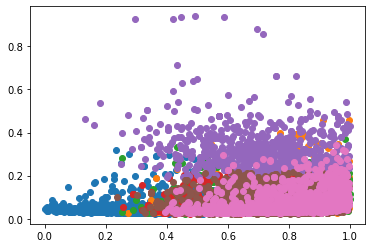

In [67]:
# assign a cluster to each example
labels = kmeans.predict(X_scaled_df)
# retrieve unique clusters
clusters = np.unique(labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(X.to_numpy()[row_ix, 1], X.to_numpy()[row_ix, 5])
    # show the plot
pyplot.show()

In [68]:
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index()

0    1244
1     594
2     790
3    2230
4     687
5    2695
6    1759
dtype: int64

In [69]:
#create dataframe from clusters
X["cluster"] = clusters
X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0.747,0.716,11,-2.457,0,0.0750,0.135000,0.000000,0.2510,0.7510,125.008,3
1,0.647,0.933,7,-4.056,1,0.1110,0.000351,0.002770,0.3340,0.3320,119.921,6
2,0.734,0.809,10,-7.264,0,0.0839,0.026600,0.000000,0.0642,0.2540,116.024,3
3,0.692,0.711,0,-7.498,0,0.0317,0.225000,0.000000,0.1200,0.8750,125.135,3
4,0.317,0.887,9,-7.292,1,0.0375,0.000582,0.002580,0.0891,0.8710,169.613,6
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.545,0.953,7,-5.172,1,0.0441,0.000941,0.117000,0.2810,0.5580,140.002,6
9995,0.337,0.977,9,-1.995,1,0.0976,0.004920,0.872000,0.2600,0.0582,169.867,2
9996,0.726,0.903,7,-2.277,0,0.0357,0.055000,0.000225,0.1580,0.9580,129.986,3
9997,0.645,0.891,6,-2.505,0,0.0387,0.093200,0.000004,0.3790,0.5680,124.915,3


### show sample from a specific cluster

In [70]:
X[X['cluster'] == 3].sample()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
8836,0.69,0.775,5,-5.116,0,0.0306,0.119,0.000533,0.125,0.962,93.241,3


#### playing with the parameters

In [71]:
#use inertia to find the best model (mean squared distance between each instance and its closest centroid) 
kmeans.inertia_

64141.13242198137

In [75]:
kmeans2 = KMeans(n_clusters=50,
                init="k-means++",
                n_init=20,  
                max_iter=10,
                tol=0,
                algorithm="elkan",
                random_state=1234)
kmeans2.fit(X_scaled_df)
print(kmeans2.inertia_)

36798.633531370186


#### choosing k

We have used K=8 by default for now - but we know that 8 might not be the optimal number of clusters for our dataset. Having a metric like inertia, we can compute it for several K values and then use the "elbow method" to choose the best K.

We will now leave all other parameters with their default value, since it seems to work pretty well.

Training a K-Means model with 2 clusters! 

Training a K-Means model with 3 clusters! 

Training a K-Means model with 4 clusters! 

Training a K-Means model with 5 clusters! 

Training a K-Means model with 6 clusters! 

Training a K-Means model with 7 clusters! 

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 

Training a K-Means model with 15 clusters! 

Training a K-Means model with 16 clusters! 

Training a K-Means model with 17 clusters! 

Training a K-Means model with 18 clusters! 

Training a K-Means model with 19 clusters! 

Training a K-Means model with 20 clusters! 



Text(0.5, 1.0, 'Elbow Method showing the optimal k')

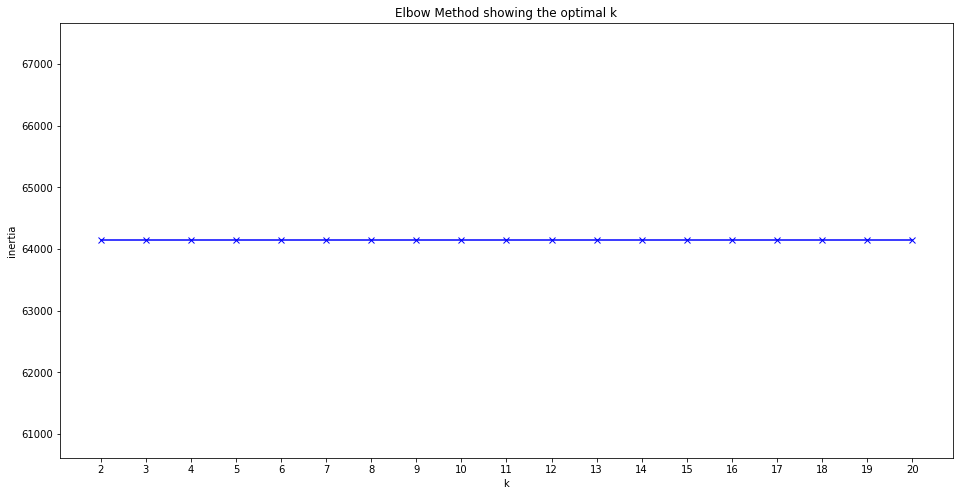

In [74]:
K = range(2, 21)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans_ = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K_, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

#### saving with pickle

In [19]:
import pickle

#scaler = StandardScaler()
#model = KMeans()

with open("scaler.pickle", "wb") as f:
    pickle.dump(scaler,f)

with open("kmeans_4.pickle", "wb") as f:
    pickle.dump(kmeans,f)

In [20]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
        
    except FileNotFoundError: 
        print("File not found!") 



In [21]:
scaler2 = load("scaler.pickle")

#### Silhouette

There's a metric called **Silhouette Score** that also measures how similar is an observation is to its own cluster compared to other clusters. For the ith observation, the **Silhouette Score** is:

$$s_{K,L} = (b - a) / max(a,b) $$

Where:

a = mean intra-cluster distance (the average distance between i and every other observation in the cluster where i belongs)

$$ a = \frac{1}{n_{K}}\sum_{i,j\neq{i}}^{n_{K}}d(i,j)$$

b = mean **nearest-cluster** distance (the average distance between i and the observations of the nearest cluster that i is not part of it)

$$ b = \frac{1}{(n_{K}*n_{L})}\sum_{i}^{n_{K}}\sum_{j}^{n_{L}}d(i,j)$$

The silhouette score for the whole model is the **average of all the silhouette scores** of each instance.

$$ S = \frac{2}{N(N-1)}\sum_{c}s_{K,L}$$

Because we divide the substraction of (b-a) by the max of the two distances (which will always be b unless the observation has been wrongly assigned to a cluster it should not belong), we obtain a "normalized score", that ranges from -1 to 1, and that makes it easier to interpret.

K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    
    filename = "kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [22]:
X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0.747,0.716,11,-2.457,0,0.0750,0.135000,0.000000,0.2510,0.7510,125.008,3
1,0.647,0.933,7,-4.056,1,0.1110,0.000351,0.002770,0.3340,0.3320,119.921,6
2,0.734,0.809,10,-7.264,0,0.0839,0.026600,0.000000,0.0642,0.2540,116.024,3
3,0.692,0.711,0,-7.498,0,0.0317,0.225000,0.000000,0.1200,0.8750,125.135,3
4,0.317,0.887,9,-7.292,1,0.0375,0.000582,0.002580,0.0891,0.8710,169.613,6
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.545,0.953,7,-5.172,1,0.0441,0.000941,0.117000,0.2810,0.5580,140.002,6
9995,0.337,0.977,9,-1.995,1,0.0976,0.004920,0.872000,0.2600,0.0582,169.867,2
9996,0.726,0.903,7,-2.277,0,0.0357,0.055000,0.000225,0.1580,0.9580,129.986,3
9997,0.645,0.891,6,-2.505,0,0.0387,0.093200,0.000004,0.3790,0.5680,124.915,3


In [23]:
#concatenate dataframes with name&id and audio features
spotify_songs = pd.concat([song_df, X], axis=1)

In [24]:
spotify_songs

,name,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,Starships,2EBCVPNAG46nbgs6jXPGvv,0.747,0.716,11,-2.457,0,0.0750,0.135000,0.000000,0.2510,0.7510,125.008,3
1,Wild Strawberries,5b3Qc27BoDWebXdgtMO9hr,0.647,0.933,7,-4.056,1,0.1110,0.000351,0.002770,0.3340,0.3320,119.921,6
2,Papaoutai,34dx8DACTJsc3rsJdaEIQw,0.734,0.809,10,-7.264,0,0.0839,0.026600,0.000000,0.0642,0.2540,116.024,3
3,Sweet Dreams (Are Made of This) - Remastered,1TfqLAPs4K3s2rJMoCokcS,0.692,0.711,0,-7.498,0,0.0317,0.225000,0.000000,0.1200,0.8750,125.135,3
4,Rock and Roll - Remaster,4PRGxHpCpF2yoOHYKQIEwD,0.317,0.887,9,-7.292,1,0.0375,0.000582,0.002580,0.0891,0.8710,169.613,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,Cornfield Chase,6pWgRkpqVfxnj3WuIcJ7WP,0.545,0.953,7,-5.172,1,0.0441,0.000941,0.117000,0.2810,0.5580,140.002,6
9995,Omen,144adL7pGHEWRwute2wxzZ,0.337,0.977,9,-1.995,1,0.0976,0.004920,0.872000,0.2600,0.0582,169.867,2
9996,Dark Star - Homemade Weapons Remix,28d1X9lfagOD4iFULH4qEK,0.726,0.903,7,-2.277,0,0.0357,0.055000,0.000225,0.1580,0.9580,129.986,3
9997,러시안 룰렛 Russian Roulette,5HiSc2ZCGn8L3cH3qSwzBT,0.645,0.891,6,-2.505,0,0.0387,0.093200,0.000004,0.3790,0.5680,124.915,3


In [25]:
print(str(spotify_songs['name'][spotify_songs['cluster'] == 0].sample()).split('    ')[1].split("\n")[0])

Way down We Go


## Building the Song Recommender

In [26]:
#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= myconfig.client_id,
                                                           client_secret= myconfig.client_secret))

In [27]:
#import song database
spotify_songs.to_csv(r'spotify_songs.csv', index = False)

In [28]:
#import billboard hot 100
top_100 = pd.read_excel('billboard_top100.xlsx')

In [41]:
#input from user returns audio features from spotify
input_song = input("Please enter a song title: ")
results = sp.search(q=input_song,limit=1,market="GB")
track_id=results['tracks']['items'][0]['external_urls']["spotify"][31:]
input_dict = sp.audio_features(track_id)[0]
del input_dict["type"]
del input_dict["id"]
del input_dict["track_href"]
del input_dict["analysis_url"]
del input_dict["duration_ms"]
del input_dict["time_signature"]
del input_dict["uri"]
input_dict

Please enter a song title: heat waves


{'danceability': 0.761,
 'energy': 0.525,
 'key': 11,
 'loudness': -6.9,
 'mode': 1,
 'speechiness': 0.0944,
 'acousticness': 0.44,
 'instrumentalness': 6.7e-06,
 'liveness': 0.0921,
 'valence': 0.531,
 'tempo': 80.87}

In [31]:
#turn audio features into list
input_list=list(input_dict.values())  
input_list

[0.761, 0.525, 11, -6.9, 1, 0.0944, 0.44, 6.7e-06, 0.0921, 0.531, 80.87]

In [32]:
#turn audio features into array
input_array = np.array(input_list).reshape(1,-1)
input_array

array([[ 7.610e-01,  5.250e-01,  1.100e+01, -6.900e+00,  1.000e+00,
         9.440e-02,  4.400e-01,  6.700e-06,  9.210e-02,  5.310e-01,
         8.087e+01]])

In [33]:
#scale audio features
input_array_scaled = scaler.transform(input_array)
input_array_scaled

/opt/anaconda3/envs/DA_ENV/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[ 1.00994758, -0.90992381,  1.58097019, -0.05288619,  0.77730524,
         0.11023968,  1.06582715, -0.40922981, -0.64078427,  0.07799224,
        -1.56812336]])

In [42]:
#turn audio features into dataframe
input_df = pd.DataFrame(data=input_array_scaled, index=None,columns=input_dict.keys())
input_df = pd.DataFrame(input_df)
input_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1.009948,-0.909924,1.58097,-0.052886,0.777305,0.11024,1.065827,-0.40923,-0.640784,0.077992,-1.568123


In [44]:
#use kmeans predict on audio features dataframe to return cluster for song input
cluster_label = kmeans.predict(input_df)
cluster_label

array([5], dtype=int32)

## Recommender Function

In [37]:
#function to show whether song is in the hot 100 and to suggest another song from the same cluster

def user_search():
    user_input = input("Please enter a song title: ")
    from IPython.display import IFrame

    #searching for track_id of input-song
    results = sp.search(q=user_input,limit=1,market="GB")
    track_id=results['tracks']['items'][0]['external_urls']["spotify"][31:]
    
    # getting the spotify audio features of the song & delete unnecassary features
    input_dict = sp.audio_features(track_id)[0]
    del input_dict["type"]
    del input_dict["id"]
    del input_dict["track_href"]
    del input_dict["analysis_url"]
    del input_dict["duration_ms"]
    del input_dict["time_signature"]
    del input_dict["uri"]
    
    # standard scaling 
    input_list=list(input_dict.values())  
    input_array = np.array(input_list).reshape(1,-1)
    input_array_scaled = scaler.transform(input_array)
    
    # getting cluster label for user_song
    input_df = pd.DataFrame(data=input_array_scaled, index=None,columns=input_dict.keys())
    input_df = pd.DataFrame(input_df)
    cluster_label = kmeans.predict(input_df)
    
    if top_100['song_title'].str.contains(user_input).any():
        artists_of_song = list(top_100['song_artist'][top_100['song_title'] == user_input].values)
        if len(artists_of_song) == 1:
            song_artist = artists_of_song[0]
            print("Your song is by",song_artist,"and belongs to the Hot100")
            print("Another song from the Top100 that you might like:", np.random.choice(top_100['song_title']))
        elif len(artists_of_song) > 1:
            song_artist1 = artists_of_song[0]
            song_artist2 = artists_of_song[1]
            print("Your song belongs to the Hot100, but has two different interprets: ",song_artist1, "&", song_artist2)
            print("Another song from the Top100 that you might like:", np.random.choice(top_100['song_title']))
    else:
        for cluster_index in range(7):
            if cluster_label == cluster_index:
                print("Your song is not in the Hot100")
                print("Maybe you like this song:", str(spotify_songs['name'][spotify_songs['cluster'] == cluster_index].sample()).split('    ')[1].split("\n")[0])
                IFrame(src="https://open.spotify.com/embed/track/"+spotify_songs['id'][cluster_index],
                       width="320",
                       height="80",
                       frameborder="0",
                       allowtransparency="true",
                       allow="encrypted-media",
                      )


In [38]:
user_search()

Please enter a song title: heat waves
Your song is not in the Hot100
Maybe you like this song: Me, Myself and I


/opt/anaconda3/envs/DA_ENV/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [39]:
#embed songplayer

from IPython.display import IFrame

IFrame(src="https://open.spotify.com/embed/track/"+spotify_songs['id'][1],
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )